In [1]:
import torch
from math import pi, sin, cos
from numpy import random, array, append, isnan
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.spatial import ConvexHull

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

这里是由于torch和matplotlib有一个MKL相关的冲突，直接忽略即可。见[链接](https://stackoverflow.com/questions/53014306/error-15-initializing-libiomp5-dylib-but-found-libiomp5-dylib-already-initial)。

In [3]:
%matplotlib inline

In [4]:
cls2k = dict()
k2cls = list()
k = 0
X_temp = list()
n = 0
Gamma_temp = list()
with open('iris.data') as f:
    while True:
        line = f.readline().rstrip('\n')
        if not line:
            break
        temp_list = line.split(',')
        temp_cls = temp_list.pop()
        if temp_cls not in cls2k:
            cls2k[temp_cls] = k
            while k >= len(k2cls):
                k2cls.append(0)
            k2cls[k] = temp_cls
            k += 1
        X_temp.append([float(n) for n in temp_list])
        Gamma_temp.append((cls2k[temp_cls], n))
        n += 1
d = len(temp_list)

读文件数据，并初始化聚类数$k$，数据数$n$，特征数$d$。

In [5]:
X = Gamma = N = Mu = Sigma = Pi = None
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
def init(random_init=False, seed=0):
    global k, X, Gamma, device
    random.seed(seed)
    X = torch.tensor(X_temp, dtype=float).to(device)  # N * D
    Gamma = torch.zeros([k, n], dtype=float).to(device)  # K * N
    for x, y in Gamma_temp:
        if random_init:
            randl = random.rand(k)
            randl /= randl.sum()
            for x, rand in enumerate(randl):
                Gamma[x][y] = rand
        else:
            Gamma[x][y] = 1

#### 初始化：
1. $X$
    - 含义：各个数据的特征
    - 形状：$n\times d$
2. $\Gamma$
    - 含义：$P(Clusters|X)$
    - 形状：$k\times n$

In [7]:
def M():
    global k, n, d, X, Gamma, N, Mu, Sigma, Pi
    N = Gamma.sum(axis=1, keepdims=True)  # K * 1
    Mu = (Gamma @ X) / N  # K * D
    EX2 = (Gamma @ (X.reshape(n, d, 1) @ X.reshape(n, 1, d)).reshape(n, -1)
           / N).reshape(k, d, d)  # K * D * D
    Sigma = EX2 - Mu.reshape(k, d, 1) @ Mu.reshape(k, 1, d)  # K * D * D
    Pi = N / n  # K * 1

#### M step:
1. $N$
    - 含义：各个聚类的大小
    - 形状：$k\times1$
    - 计算：$N=\sum_i\Gamma_{[:, i]}$
2. $M$
    - 含义：各个聚类各个特征的均值
    - 形状：$k\times d$
    - 计算：$M_{[i,j]}=(\Gamma\cdot X)_{[i,j]}/N_{[i,0]}$
3. $\Sigma$
    - 含义：各个聚类各个特征的协方差
    - 形状：$k\times d\times d$
    - 计算：$\Sigma_{[i,:,:]}=\sum_j\Gamma_{[i,j]}\cdot(X_{[j,:]}-M_{[i,:]})\cdot(X_{[j,:]}-M_{[i,:]})^T/N_{[i,0]}$，因为$X$和$M$第一维长度不同，难以用矩阵并行运算。

    可以做一些变形：
    $$\begin{aligned}
    &\sum_j\Gamma_{[i,j]}\cdot(X_{[j,:]}-M_{[i,:]})\cdot(X_{[j,:]}-M_{[i,:]})^T/N_{[i,0]}\\
    =&\sum_j\Gamma_{[i,j]}\cdot(X_{[j,:]}\cdot X_{[j,:]}^T-X_{[j,:]}\cdot M_{[i,:]}^T
    -M_{[i,:]}\cdot X_{[j,:]}^T+M_{[i,:]}\cdot M_{[i,:]}^T)/N_{[i,0]}\\
    =&\sum_j\Gamma_{[i,j]}\cdot X_{[j,:]}\cdot X_{[j,:]}^T/N_{[i,0]}
    -(\sum_j\Gamma_{[i,j]}\cdot X_{[j,:]}/N_{[i,0]})\cdot M_{[i,:]}^T
    -M_{[i,:]}\cdot\sum_j\Gamma_{[i,j]}\cdot X_{[j,:]}^T/N_{[i,0]}
    +M_{[i,:]}\cdot M_{[i,:]}^T\sum_j\Gamma_{[i,j]}/N_{[i,0]}\\
    =&\sum_j\Gamma_{[i,j]}\cdot X_{[j,:]}\cdot X_{[j,:]}^T/N_{[i,0]}
    -M_{[i,:]}\cdot M_{[i,:]}^T-M_{[i,:]}\cdot M_{[i,:]}^T+M_{[i,:]}\cdot M_{[i,:]}^T\\
    =&\sum_j\Gamma_{[i,j]}\cdot X_{[j,:]}\cdot X_{[j,:]}^T/N_{[i,0]}-M_{[i,:]}\cdot M_{[i,:]}^T
    \end{aligned}$$

    然后定义：
        - $X$形状$n\times d\times 1$
        - $M$形状$k\times d\times 1$
        - 2d矩阵$\cdot$3d矩阵是对后两维点乘（即`@`）
        - 2d矩阵$\cdot$3d矩阵是将3d矩阵的后两维展平成一维使其成为2d矩阵，再做点乘，再将结果最后一维恢复成两维使结果成为3d矩阵
        - 3d矩阵/2d矩阵是将3d矩阵的后两维展平成一维使其成为2d矩阵，再广播地对每个元素做除法，再将结果最后一维恢复成两维使结果成为3d矩阵

    就有：
    $\Sigma=\Gamma\cdot(X\cdot X^T)/N-M\cdot M^T$，可以用矩阵并行计算优化。
4. $\Pi$
    - 含义：$P(Clusters)$
    - 形状：$k\times1$
    - 计算：$\Pi_{[i,0]}=N_{[i,0]}/n$

In [8]:
def E(evaluate=True):
    global k, n, d, X, Gamma, N, Mu, Sigma, Pi
    X_minus_Mu = X.reshape(1, n, d) - Mu.reshape(k, 1, d)  # K * N * D
    numerator = ((X_minus_Mu @ Sigma.inverse() * X_minus_Mu).sum(axis=2)
                 / (-2)).exp()  # K * N
    denominator = (2 * pi) ** (d / 2)\
        * Sigma.det().reshape(k, 1) ** 0.5  # K * 1
    Nu = numerator / denominator  # K * N
    Pi_mul_Nu = Pi * Nu  # K * N
    Pi_mul_Nu_sum = Pi_mul_Nu.sum(axis=0)
    Gamma = Pi_mul_Nu / Pi_mul_Nu_sum
    if evaluate:
        return Pi_mul_Nu_sum.log().sum(axis=0).cpu()

#### E step:
1. $numerator$
    - 含义：概率密度函数的分子部分
    - 形状：$k\times n$
    - 计算：还是因为$X$和$M$第一维长度不同，因而难以用矩阵并行运算。

        但是最复杂的部分可以将$X-M$形状变成$k\times n\times d$。这样：
        - 计算$(X-M)\cdot\Sigma^{-1}$，获得一个$k\times n\times d$的矩阵
        - 广播地计算$((X-M)\cdot\Sigma^{-1})_{[i,j,m]}\cdot(X-M)_{[i,j,m]}$，获得一个$k\times n\times d$的矩阵
        - 计算$\sum_m((X-M)\cdot\Sigma^{-1})_{[i,j,m]}\cdot(X-M)_{[i,j,m]}$，获得一个$k\times n\times 1$的矩阵
        
    这样：
    $numerator=\exp(\sum_m((X-M)\cdot\Sigma^{-1})_{[i,j,m]}\cdot(X-M)_{[i,j,m]}/(-2))$

2. $denominator$
    - 含义：概率密度函数的分母部分
    - 形状：$k\times1$
    - 计算：$denominator_{[i,0]}=(2\pi)^{d/2}|\Sigma_{[i,0]}|^{0.5}$

In [9]:
def show_clusters(digit=5, distance=5.991 ** 0.5):
    global k, d, X, Gamma, Mu, Sigma, device
    fig = plt.figure()
    plt.subplots_adjust(right=2)
    fig.suptitle('Clusters', fontsize=20, x=1)
    X_Mu = append(X.cpu(), Mu.cpu(), 0)

    # 算高维的椭圆边界上的点
    base = int(pi * digit) + 1
    Eigval = list()
    Eigvec = list()
    for kk in range(k):
        sigma = Sigma[kk]
        eigval, eigvec = torch.eig(sigma, eigenvectors=True)
        Eigval.append(eigval.cpu().numpy())
        Eigvec.append(eigvec.cpu().numpy())
    Eigval = torch.tensor(array(Eigval)).to(device)[:, :, 0:1]
    Eigvec = torch.tensor(array(Eigvec)).to(device)
    ellipse = list()
    temp_Mu = Mu.reshape(k, d, 1)
    for i in range(base ** (d - 1)):
        # θ_0, θ_1, ..., θ_{d-2}各取一个值
        theta = list()
        for j in range(d - 1):
            theta.append(i % base / digit)
            i //= base
        # 求cos(θ_0) * cos(θ_1) * ... * cos(θ_{d-1-j-1}) * sin(θ_{d-1-j})
        sin_theta = list()
        for j in range(d):
            sin_theta.append(1)
            for m in range(d - 1):
                if m == d - 1 - j:
                    sin_theta[-1] *= sin(theta[m])
                    break
                sin_theta[-1] *= cos(theta[m])
        ellipse.append((Eigvec @ (Eigval ** 0.5 * torch.tensor(sin_theta)
                                  .to(device).reshape(1, d, 1)) * distance
                        + temp_Mu).reshape(k, d).cpu().numpy())
    X_Mu_ellipse = append(X_Mu, array(ellipse).transpose(1, 0, 2)
                          .reshape(-1, d), 0)

    # 用PCA对X,Mu,ellipse降维
    plt.subplot(121)
    X_Mu_ellipse_PCA = PCA().fit_transform(X_Mu_ellipse)
    plt.title('Embedded by PCA')
    # 画X
    plt.scatter(X_Mu_ellipse_PCA[:X.shape[0], 0],
                X_Mu_ellipse_PCA[:X.shape[0], 1], c=Gamma.T.cpu().numpy())
    # 画ellipse
    left = X.shape[0] + k
    right = left + base ** (d - 1)
    while left < X_Mu_ellipse_PCA.shape[0]:
        hull = ConvexHull(X_Mu_ellipse_PCA[left:right, :2])
        for simplex in hull.simplices:
            plt.plot(X_Mu_ellipse_PCA[left + simplex, 0],
                     X_Mu_ellipse_PCA[left + simplex, 1], color='k')
        left = right
        right += base ** (d - 1)
    # 画Mu
    plt.scatter(X_Mu_ellipse_PCA[X.shape[0]:X.shape[0] + k, 0],
                X_Mu_ellipse_PCA[X.shape[0]:X.shape[0] + k, 1], s=200,
                c=['r', 'g', 'b'], marker='*', edgecolors='k', linewidths=2)

    # 用TSNE对X,Mu降维
    plt.subplot(122)
    X_Mu_TSNE = TSNE().fit_transform(X_Mu)
    plt.title('Embedded by TSNE')
    # 画X
    plt.scatter(X_Mu_TSNE[:-3, 0], X_Mu_TSNE[:-3, 1],
                c=Gamma.T.cpu().numpy(), marker='.')
    # 画Mu
    plt.scatter(X_Mu_TSNE[-3:, 0], X_Mu_TSNE[-3:, 1], s=200,
                c=['r', 'g', 'b'], marker='*', edgecolor='k', linewidths=2)

    plt.show()

#### 聚类可视化
1. $X$
    - 表示：2d图像上点的位置
    - 细节：由于$X$有4个特征，是4d图像上的点，需要使用一些方法将其降到2d。这里使用了：
        - PCA
            - [原理](https://blog.csdn.net/luoluonuoyasuolong/article/details/90711318)
            - [接口](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html?highlight=pca#sklearn.decomposition.PCA)
        - TSNE
            - [原理](https://zhuanlan.zhihu.com/p/49073961)
            - [接口](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html?highlight=tsne#sklearn.manifold.TSNE)

2. $\Gamma$
    - 表示：2d图像上点的颜色
    - 细节：3种聚类刚好可以分别对应r,g,b

3. $M$
    - 表示：2d图像上*的位置，其颜色对应一个聚类
    - 细节：同样需要降维，为了让其和$X$一致，将其先和$X$拼接，再一起用PCA和TSNE降维

4. $\Sigma$
    - 表示：2d图像上黑色闭合曲线
    - 细节：
        - 由于$N(X|\mu,\Sigma)=f((X-\mu)\cdot\Sigma^{-1}\cdot(X-\mu)^T)$，由$N(X|\mu,\Sigma)\ge p$可以得到一个以$\mu$为圆心的椭圆，椭圆的长轴短轴旋转角度等参数取决于$\Sigma$，因此可以通过椭圆的边界来可视化$\Sigma$
        - 边界的点计算参考[链接](https://cookierobotics.com/007/)，同样运用特征向量特征值和椭圆参数方程做计算，不同的是这里是$d$维的椭圆
        - $d$维的椭圆的参数方程有$d-1$个参数，定义符号：
        $$end_i=\begin{cases}
        sin(\theta_i),&0\le i<d-1\\
        1,&i=d-1
        \end{cases}$$
        这样第$j$个特征可表示成$\cos(\theta_0)\cdots\cos(\theta_{d-1-j-1})end_{d-1-j}$
        - 同样需要降维，为了让其和$X,M$一致，将其先和$X,M$拼接，再一起用PCA降维
        - 不使用TSNE降维，因为根据TSNE原理不能保持椭圆形状，而且计算太慢
        - PCA可以保持形状，因为PCA是高维图像在低维的投影
        - 低维下点会构成一个面而不是一个边界而是一个面（考虑三维椭圆边界向二维投影获得的也是一个面），用[ConvexHull](https://stackoverflow.com/questions/36763853/plotting-a-set-of-given-points-to-form-a-closed-curve-in-matplotlib)画出其边界
        - 聚类的点有95%的概率落在该边界内

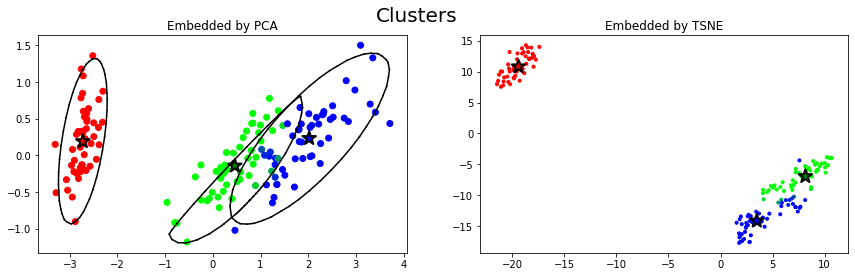

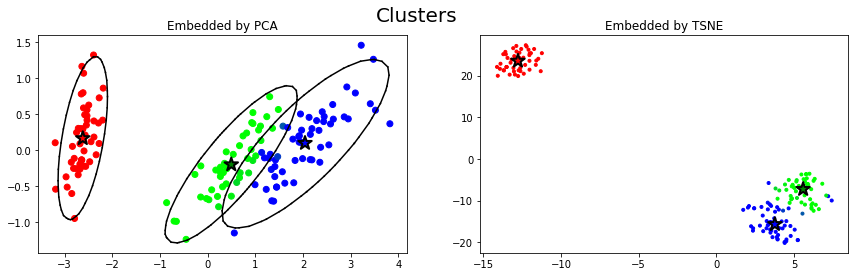

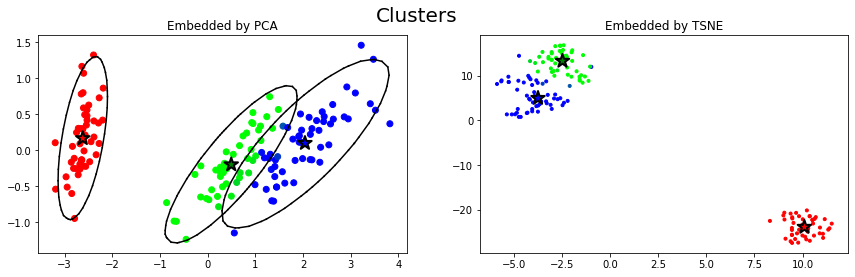

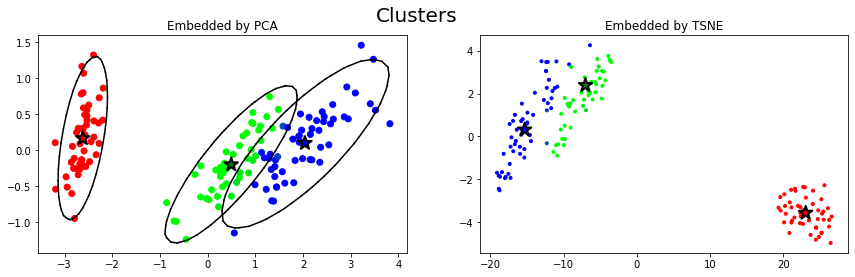

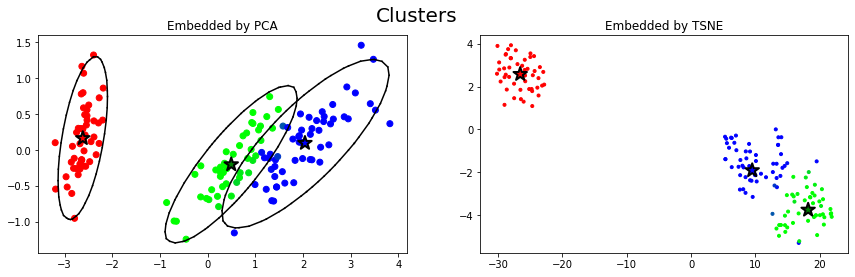

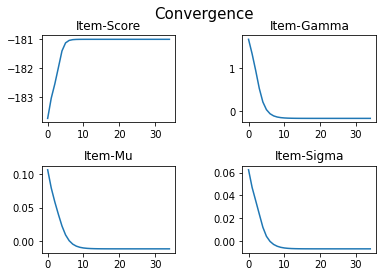

In [10]:
init()
score_list = list()
Gamma_list = list()
Mu_list = list()
Sigma_list = list()
ite = 0
digit = 0
freq = 10
while True:
    M()
    score = E()
    if isnan(score):
        break
    if score_list != [] and abs(score - score_list[-1]) <= digit:
        break
    if ite % freq == 0:
        show_clusters()
    score_list.append(score)
    Gamma_list.append(Gamma.flatten().cpu().numpy())
    Mu_list.append(Mu.flatten().cpu().numpy())
    Sigma_list.append(Sigma.flatten().cpu().numpy())
    ite += 1
show_clusters()
score_list = array(score_list)
Gamma_list = array(Gamma_list)
Mu_list = array(Mu_list)
Sigma_list = array(Sigma_list)

X_minus_Mu = X.reshape(1, n, d) - Mu.reshape(k, 1, d)  # K * N * D
numerator = ((X_minus_Mu @ Sigma.inverse() * X_minus_Mu).sum(axis=2)
             / (-2)).exp()  # K * N
denominator = (2 * pi) ** (d / 2)\
    * Sigma.det().reshape(k, 1) ** 0.5  # K * 1
Nu = numerator / denominator  # K * N
Pi_mul_Nu = Pi * Nu  # K * N
Pi_mul_Nu_sum = Pi_mul_Nu.sum(axis=0)
Gamma = Pi_mul_Nu / Pi_mul_Nu_sum
(X_minus_Mu @ Sigma.inverse() * X_minus_Mu).sum(axis=2)

fig = plt.figure()
plt.subplots_adjust(wspace=0.5, hspace=0.5)
fig.suptitle('Convergence', fontsize=15)

plt.subplot(221)
plt.title('Item-Score')
plt.plot(range(len(score_list)), score_list)

plt.subplot(222)
Gamma_list_embedded = PCA(1).fit_transform(Gamma_list)
plt.title('Item-Gamma')
plt.plot(range(len(Gamma_list_embedded)), Gamma_list_embedded)

plt.subplot(223)
Mu_list_embedded = PCA(1).fit_transform(Mu_list)
plt.title('Item-Mu')
plt.plot(range(len(Mu_list_embedded)), Mu_list_embedded)

plt.subplot(224)
Sigma_list_embedded = PCA(1).fit_transform(Sigma_list)
plt.title('Item-Sigma')
plt.plot(range(len(Sigma_list_embedded)), Sigma_list_embedded)

这是所给数据集的结果，虽然从Item-Score,Item-Gamma,Item-Mu,Item-Sigma图上看，是上升且最后收敛，但是从clusters图上看几张图几乎没有变化，可以得知初始化的时候已经接近收敛了。

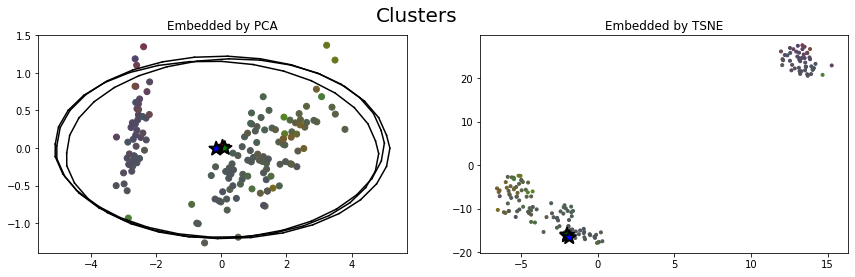

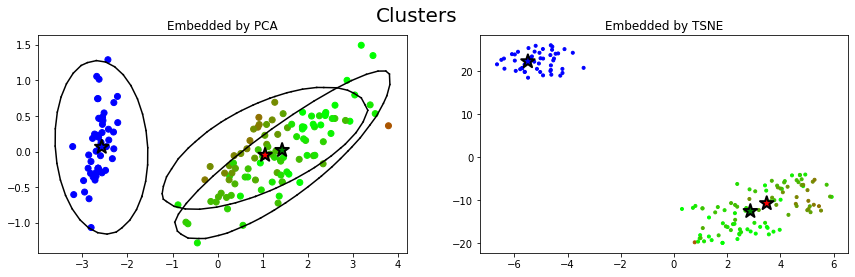

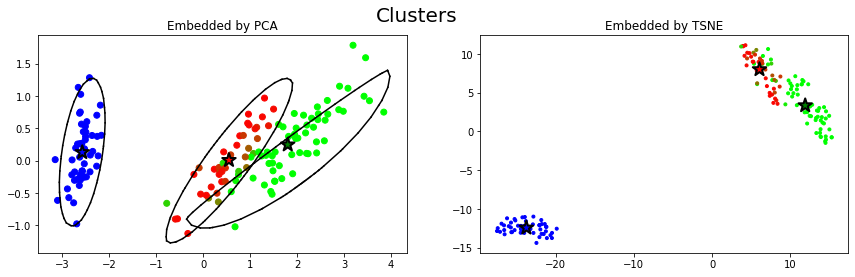

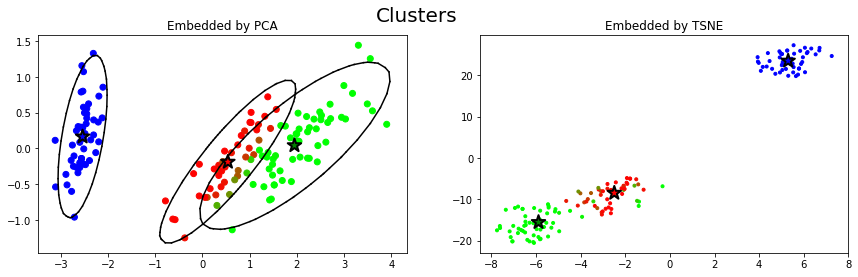

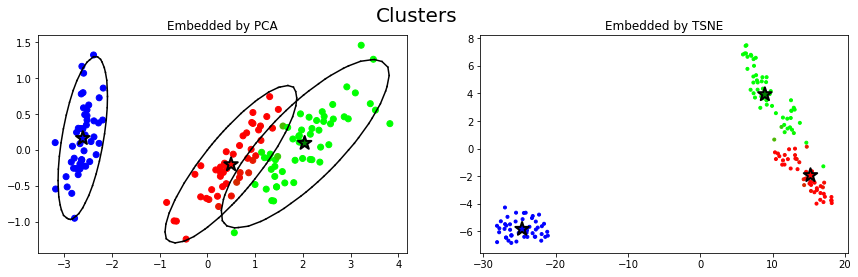

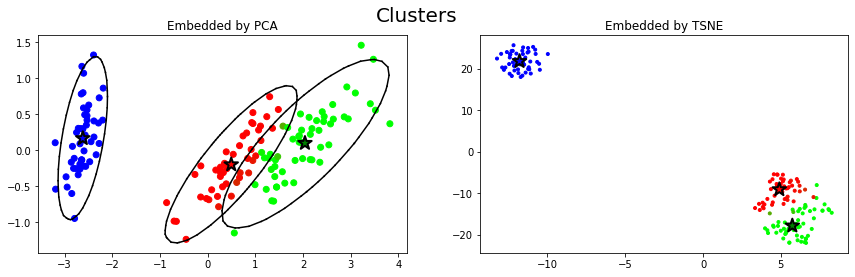

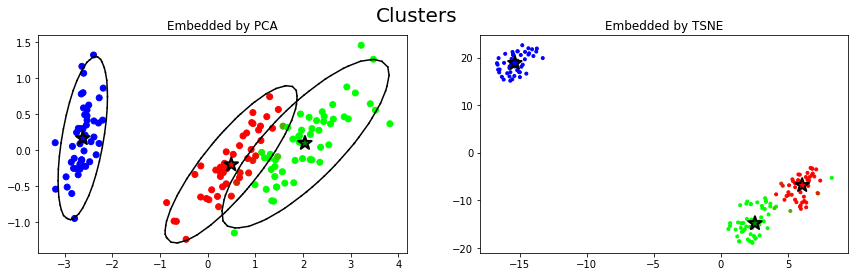

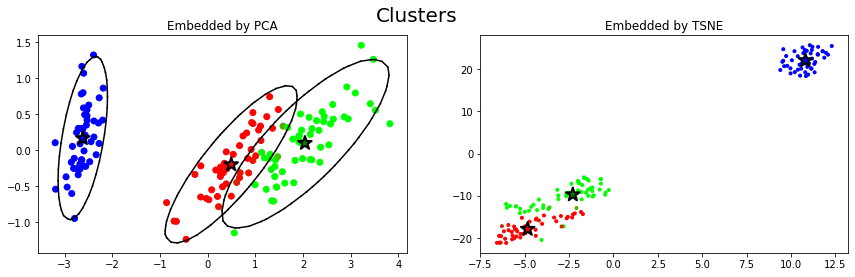

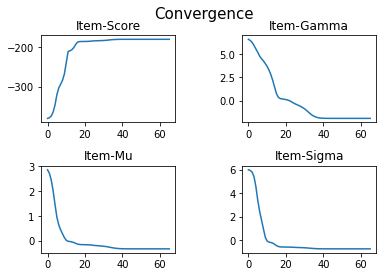

In [11]:
# seed = 36
# seed = 70
# seed = 76
seed = 279  # nice
# seed = 477
# seed = 599
# seed = 666
# seed = 861
# seed = 878
# seed = 888
# seed = 988  # nice
# seed = 1052  # nice

# while not find:
#     seed += 1
init(True, seed)
score_list = list()
Gamma_list = list()
Mu_list = list()
Sigma_list = list()
ite = 0
digit = 0
freq = 10
while True:
    M()
    score = E()
    if isnan(score):
        break
    # if score > -190:
    #     find = True
    #     break
    if score_list != [] and abs(score - score_list[-1]) <= digit:
        break
    if ite % freq == 0:
        show_clusters()
    score_list.append(score)
    Gamma_list.append(Gamma.flatten().cpu().numpy())
    Mu_list.append(Mu.flatten().cpu().numpy())
    Sigma_list.append(Sigma.flatten().cpu().numpy())
    ite += 1
show_clusters()
score_list = array(score_list)
Gamma_list = array(Gamma_list)
Mu_list = array(Mu_list)
Sigma_list = array(Sigma_list)
# seed

X_minus_Mu = X.reshape(1, n, d) - Mu.reshape(k, 1, d)  # K * N * D
numerator = ((X_minus_Mu @ Sigma.inverse() * X_minus_Mu).sum(axis=2)
             / (-2)).exp()  # K * N
denominator = (2 * pi) ** (d / 2)\
    * Sigma.det().reshape(k, 1) ** 0.5  # K * 1
Nu = numerator / denominator  # K * N
Pi_mul_Nu = Pi * Nu  # K * N
Pi_mul_Nu_sum = Pi_mul_Nu.sum(axis=0)
Gamma = Pi_mul_Nu / Pi_mul_Nu_sum
(X_minus_Mu @ Sigma.inverse() * X_minus_Mu).sum(axis=2)

fig = plt.figure()
plt.subplots_adjust(wspace=0.5, hspace=0.5)
fig.suptitle('Convergence', fontsize=15)

plt.subplot(221)
plt.title('Item-Score')
plt.plot(range(len(score_list)), score_list)

plt.subplot(222)
Gamma_list_embedded = PCA(1).fit_transform(Gamma_list)
plt.title('Item-Gamma')
plt.plot(range(len(Gamma_list_embedded)), Gamma_list_embedded)

plt.subplot(223)
Mu_list_embedded = PCA(1).fit_transform(Mu_list)
plt.title('Item-Mu')
plt.plot(range(len(Mu_list_embedded)), Mu_list_embedded)

plt.subplot(224)
Sigma_list_embedded = PCA(1).fit_transform(Sigma_list)
plt.title('Item-Sigma')
plt.plot(range(len(Sigma_list_embedded)), Sigma_list_embedded)

这是随机初始化聚类的结果。遍历seed=0~1052，找到得分能超过$-190$的seed（写在开头的注释中），并挨个看clusters图，找到几个收敛很好的seed（标注了nice），在此展示其中一个很好的seed。可以明显看到，初始各个椭圆及其圆心比较重合，每个点颜色比较一致，后面椭圆分离明显，颜色也是分离明显，最后几次结果变化很小表示收敛。